In [1]:
%load_ext autoreload
%autoreload 2

# Load Dependencies

In [2]:
import matplotlib.pyplot as plt

import torch

import pyro
import numpy as np
import pyro.distributions as dist
# from pyro.poutine import trace, replay, block
# from pyro.infer.autoguide.guides import AutoDelta, AutoNormal
# from pyro.infer import SVI, Trace_ELBO, Predictive

import sys
sys.path.append("../../src/")

from pyciemss.ODE.askem_primitives import sample, infer_parameters, intervene, optimization

# from pyciemss.utils import run_inference, get_tspan
from pyciemss.utils import get_tspan

import warnings
warnings.filterwarnings('ignore')

# Plotting Utilities

In [ ]:
def setup_ax(ax=None):

    if not ax:
        fig = plt.figure(facecolor='w', figsize=(9, 5))
        ax = fig.add_subplot(111, axisbelow=True)

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Total infected')
    return ax

def plot_predictive(prediction, tspan, tmin=None, ax=None, alpha=0.2, color="black", **kwargs):
    vars = ["I_total_obs"]
    #infection_total = sum([prediction[x].squeeze().detach().numpy()/1000. for x in ['I_obs', 'D_obs', 'A_obs', 'R_obs', 'T_obs']])

    I_low = torch.quantile(prediction["I_total_obs"], 0.05, dim=0).detach().numpy()
    I_up = torch.quantile(prediction["I_total_obs"], 0.95, dim=0).detach().numpy()

    if tmin:
        indeces = tspan >= tmin
    else:
        indeces = torch.ones_like(tspan).bool()

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    
    ax.fill_between(tspan[indeces], I_low[indeces], I_up[indeces], alpha=alpha, color=color, **kwargs)

    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)

    return ax

def plot_trajectory(data, tspan, ax=None, color='black', alpha=0.5, lw=0, marker='.', label=None):
    # Plot the data on three separate curves for S(t), I(t) and R(t)

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    #infection_total = sum([data[x].squeeze().detach().numpy()/1000. for x in ['I_obs', 'D_obs', 'A_obs', 'R_obs', 'T_obs']])
    ax.plot(tspan, data['I_total_obs'].squeeze().detach().numpy(), color, alpha=alpha, lw=lw, marker=marker, label=label)
    
    return ax

def plot_intervention_line(t, ax=None):
    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ylim = ax.get_ylim()

    ax.vlines(t, min(ylim), max(ylim), color="grey", ls='-')

    return ax

def sideaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return

def sideaxishist(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # For y-axis
    ax.yaxis.set_major_locator(ticker.NullLocator())
    ax.tick_params(axis='x', labelsize=12)  # change fontsize for x-axis tick labels
    # ax.xaxis.major.formatter._useMathText = True
    return

In [3]:
def LogNormalPrior(mean, variance):
    mu = torch.log(mean**2/torch.sqrt((mean**2 + variance)))
    scale = torch.sqrt(torch.log(1 + variance/mean**2))
    return dist.LogNormal(mu, scale)

# Setup Parameters

In [26]:
full_tspan = get_tspan(1, 100, 100)

num_samples = 500

# Total population, N.
N = 1
# Initial number of infected and recovered individuals, I0 and R0.
I0, D0, A0, R0, T0, H0, E0 = 200/60e6, 20/60e6, 1/60e6, 2/60e6, 0, 0, 0

# Everyone else, S0, is susceptible to infection initially.

S0 = N - I0 - D0 - A0 - R0 - T0 - H0 - E0


#I_obs = torch.tensor([81.47, 84.3, 86.44, 89.66, 93.32, 94.1, 96.31])

initial_state = tuple(torch.as_tensor(s) for s in  (S0, I0, D0, A0, R0, T0, H0, E0))
# final_observed_state = tuple(torch.as_tensor(s) for s in  (S0, I0, D0, A0, R0, T0, H0, E0))

# Probabilistic Forecasting - Passing unit test 1
There are two ‘unit tests’ we want to pass, to ensure that we understood and can reproduce the published model:

## 1.a Unit Test \#1:

Set the initial values and parameters, as described in the Supplementary Methods section of the publication (pg. 9 of the pdf): 

1. Initial Values: 
* $I = 200/60e6$,
* $D = 20/60e6$, 
* $A = 1/60e6$, 
* $R = 2/60e6$, 
* $T = 0$, 
* $H = 0$, 
* $E = 0$; 
* $S = 1 – I – D – A – R – T – H – E$. 

Let total population = 60e6.
Parameters: $$\alpha = 0.570, \beta = \delta  = 0.011, \gamma = 0.456, \epsilon = 0.171, \theta = 0.371, \zeta = \eta = 0.125, \mu = 0.017, \nu = 0.027, \tau = 0.01, \lambda = \rho = 0.034$$ and $$\kappa = \xi = \sigma = 0.017$$.

### Deterministic forecasting

In [5]:
from pyciemss.ODE.models import SIDARTHE

pyro.set_rng_seed(0)

ode_model = SIDARTHE(N=1,
                 alpha_prior=dist.Delta(torch.tensor (0.570)) ,
                 beta_prior=dist.Delta(torch.tensor (0.011)) ,
                 gamma_prior=dist.Delta(torch.tensor (0.456)) ,
                 delta_prior=dist.Delta(torch.tensor (0.011)) ,
                 epsilon_prior=dist.Delta(torch.tensor (0.171)) ,
                 lamb_prior =dist.Delta(torch.tensor (0.034)) ,
                 zeta_prior=dist.Delta(torch.tensor (0.125)) ,
                 eta_prior=dist.Delta(torch.tensor (0.125)) ,
                 kappa_prior=dist.Delta(torch.tensor (0.017)) ,
                 theta_prior=dist.Delta(torch.tensor (0.371)) ,
                 rho_prior=dist.Delta(torch.tensor (0.034)) ,
                 xi_prior=dist.Delta(torch.tensor (0.017)) ,
                 sigma_prior=dist.Delta(torch.tensor (0.017)) ,
                 mu_prior=dist.Delta(torch.tensor (0.017)) ,
                 nu_prior=dist.Delta(torch.tensor (0.027)) ,
                 tau_prior=dist.Delta(torch.tensor (0.01)) )

In [6]:
#prior_prediction = sample(plotting_ode_model, num_samples, initial_state, full_tspan)
single_prediction = sample(ode_model, 1, initial_state, full_tspan)

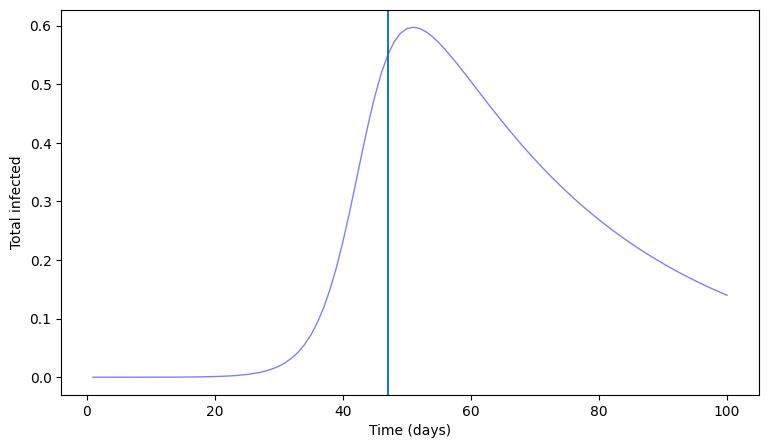

In [7]:
ax = plot_trajectory(single_prediction, full_tspan, ax=setup_ax(), color="blue", marker='', lw=1., label="Before Seeing Data - Single Forecast")
#ax = plot_predictive(prior_prediction, full_tspan, ax=ax, label="Before Seeing Data - Probabilistic Forecast", color="red")
ax.axvline(47)

### Probabilistic forecasting

In [8]:
from pyciemss.ODE.models import SIDARTHE

pyro.set_rng_seed(0)

var_prior = 0.05**2

ode_model = SIDARTHE(N=1,
                 alpha_prior=LogNormalPrior(torch.tensor(0.570), torch.tensor(var_prior)) ,
                 beta_prior=LogNormalPrior(torch.tensor(0.011), torch.tensor(var_prior)) ,
                 gamma_prior=LogNormalPrior(torch.tensor(0.456), torch.tensor(var_prior)) ,
                 delta_prior=LogNormalPrior(torch.tensor(0.011), torch.tensor(var_prior)) ,
                 epsilon_prior=LogNormalPrior(torch.tensor(0.171), torch.tensor(var_prior)) ,
                 lamb_prior =LogNormalPrior(torch.tensor(0.034), torch.tensor(var_prior)) ,
                 zeta_prior=LogNormalPrior(torch.tensor(0.125), torch.tensor(var_prior)) ,
                 eta_prior=LogNormalPrior(torch.tensor(0.125), torch.tensor(var_prior)) ,
                 kappa_prior=LogNormalPrior(torch.tensor(0.017), torch.tensor(var_prior)) ,
                 theta_prior=LogNormalPrior(torch.tensor(0.371), torch.tensor(var_prior)) ,
                 rho_prior=LogNormalPrior(torch.tensor(0.034), torch.tensor(var_prior)) ,
                 xi_prior=LogNormalPrior(torch.tensor(0.017), torch.tensor(var_prior)) ,
                 sigma_prior=LogNormalPrior(torch.tensor(0.017), torch.tensor(var_prior)) ,
                 mu_prior=LogNormalPrior(torch.tensor(0.017), torch.tensor(var_prior)) ,
                 nu_prior=LogNormalPrior(torch.tensor(0.027), torch.tensor(var_prior)) ,
                 tau_prior=LogNormalPrior(torch.tensor(0.01), torch.tensor(var_prior)) )

In [9]:
prior_prediction = sample(ode_model, num_samples, initial_state, full_tspan)
# single_prediction = sample(ode_model, 1, initial_state, full_tspan)
# ax = plot_trajectory(single_prediction, full_tspan, ax=setup_ax(), color="blue", marker='', lw=1., label="Before Seeing Data - Single Forecast")

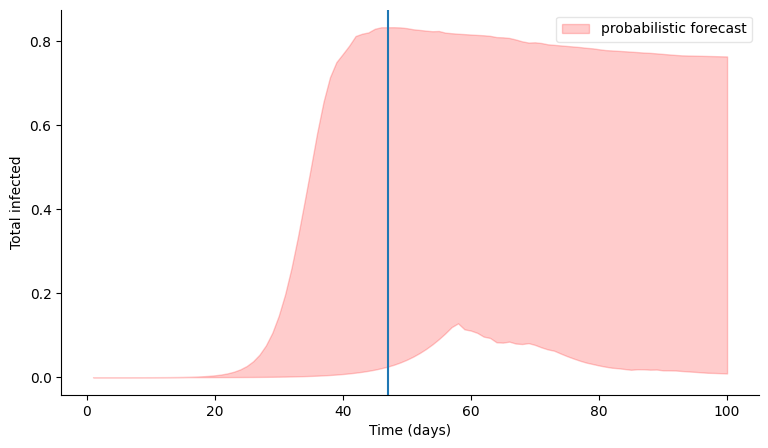

In [10]:
ax1 = plot_predictive(prior_prediction, full_tspan, ax=setup_ax(), label="probabilistic forecast", color="red")
ax1.axvline(47)
sideaxis(ax1)

## 1.d Policies that prevent infections from exceeding 1/3 of the population

Now return to the situation in b.i (constant parameters that don’t change over time). Let’s say we want to increase testing, diagnostics, and contact tracing efforts (implemented by increasing the detection parameters  and ). Assume that $\theta \ge 2\epsilon$ , because a symptomatic person is more likely to be tested. What minimum constant values do these parameters need to be over the course of a 100-day simulation, to ensure that the total infected population (sum over all the infected states I, D, A, R, T) never rises above 1/3 of the total population?


### Problem Formulation
* **Quantity of interest**:  Total infections out of $N=60,000,000$ population
$$I_{total}(t; \mathbf{u}, \mathbf{Z}) = I(t) + D(t) + A(t) + R(t) + T(t)$$

A conservative estimate for the quantity of interest is
$$M(u, Z) = \max_{1\leq t \leq 100} I_{total}(t; \mathbf{u}, \mathbf{Z})/N$$




* **Control**: $\mathbf{u}\in \mathcal{U} \subseteq \mathbb{R}^{n_u}$
    * Detection parameter for Infected ($\epsilon$) assuming that $\theta=2\epsilon$
    * Two detection parameters $\theta, \epsilon$, constraining $\theta \ge 2\epsilon$.
    


* **Risk-based optimization under uncertainty problem formulation**
    * Objective Function - Minimize the magnitude of the parameter interventions.
    * Constraint - Risk of normalized total infections exceeding the prescribed threshold of $1/3$, $\mathcal{R}( M(\mathbf{u},\mathbf{Z}))$, is below the acceptable risk threshold, $\mathcal{R}_\text{threshold}$.

\begin{equation} 
\begin{split} 
\mathbf{u}^*= \underset{\mathbf{u}\in\mathcal{U}}{\arg\min}\ & \lVert \mathbf{u} \rVert_1 \\ \text{s.t.}\ & \mathcal{R}( M(\mathbf{u}, \theta)) \le \mathcal{R}_\text{threshold} 
\end{split} 
\end{equation}

#### Formulation 1: Optimize $\epsilon$ only, assuming $\theta = 2\epsilon$
\begin{equation} 
\begin{split} 
\epsilon^*= \underset{\epsilon\in\mathcal{U}}{\arg\min}\ & \epsilon \\ \text{s.t.}\ & \mathbb{P}( M(\epsilon, \mathbf{Z}) \ge 1/3) \le 0.05
\end{split} 
\end{equation}

#### Formulation 2: Optimize $\epsilon$ and $\theta$ constraining $\theta \ge 2\epsilon$
\begin{equation} 
\begin{split} 
\epsilon^\ast, \theta^\ast= \underset{\{\epsilon,\theta\}\in\mathcal{U}}{\arg\min}\ & \theta + \epsilon \\ \text{s.t.}\ & \mathbb{P}( M(\epsilon,\theta, \mathbf{Z}) \ge 1/3) \le 0.05, \\
& \theta \ge 2\epsilon
\end{split} 
\end{equation}

Apart from probability of exceedance, we will explore quantiles and superquantiles as risk measures.

# Probabilistic forecasting - Exploring interventions


In [11]:

from causal_pyro.query.do_messenger import do
from pyciemss.ODE.interventions import constant_intervention_builder, time_dependent_intervention_builder, state_dependent_intervention_builder, parameter_intervention_builder
new_tspan = full_tspan


## Q: "What would happen if we set the diagnosis rate parameter for infected, $\epsilon$?"


In [12]:
pyro.set_rng_seed(0)

# plotting_intervened_parameter_model = intervene(ode_model, rate_parameter_intervention)
plotting_intervened_parameter_model = do(ode_model, {"epsilon": torch.tensor([0.5]), "theta": torch.tensor([1.])})
# intervened_parameter_prediction = Predictive(intervened_parameter_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)
intervened_parameter_prediction = sample(plotting_intervened_parameter_model, num_samples, initial_state, new_tspan)
# posterior_prediction = Predictive(plotting_intervened_parameter_model, guide=None, num_samples=num_samples)(initial_state, new_tspan)

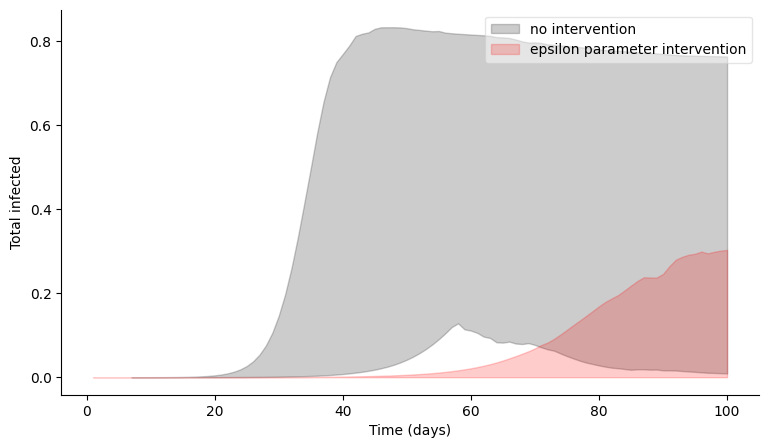

In [13]:
ax = setup_ax()
# ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(prior_prediction, new_tspan, tmin=7, ax=ax, label="no intervention")
ax = plot_predictive(intervened_parameter_prediction, new_tspan, ax=ax, color='red', label="epsilon parameter intervention")
sideaxis(ax)

In [14]:
import os
import time
import pickle

import numpy as np
from scipy import stats
from matplotlib import ticker

# from pyciemss.ODE.models import SVIIvR
from pyciemss.ODE.interventions import constant_intervention_builder, parameter_intervention_builder

from pyciemss.risk.risk_measures import alpha_quantile, alpha_superquantile
from pyciemss.risk.ouu import computeRisk, solveOUU
from pyciemss.risk.qoi import max_total_infections_SIDARTHE
import scipy


co = ['#377eb8', '#ff7f00', '#984ea3', '#ffd92f', '#a65628']
rlabel = ['Q_alpha-based OUU', 'barQ_alpha-based OUU']

## Exploring the difference between Quantiles and Superquantiles

In [15]:
torch.manual_seed(1)

POLICY = np.array([0.75])
N_SAMPLES = 500

RISK = computeRisk(model=ode_model,
#                  intervention_fun=lambda x: parameter_intervention_builder("epsilon", torch.from_numpy(x)),
                 intervention_fun=lambda x: {"epsilon": torch.from_numpy(x), "theta": torch.from_numpy(2*x)},
                 qoi=lambda y: max_total_infections_SIDARTHE(y, contexts=["I_total_obs"]),
                 risk_measure=alpha_superquantile,
                 num_samples=N_SAMPLES,
                 model_state=final_observed_state,
                 tspan=new_tspan,
                 guide=None)

start_time = time.time()
sq_dataCube = RISK.propagate_uncertainty(POLICY)
end_time = time.time()
forward_time = end_time - start_time
time_per_eval = forward_time / N_SAMPLES
print(f"Forward UQ took {forward_time:.2f} seconds total ({forward_time/N_SAMPLES:.2e} seconds per model evaluation).")
sq_qoi = RISK.qoi(sq_dataCube)
sq_sv = RISK.risk_measure(sq_qoi)

RISK.risk_measure = alpha_quantile
q_sv = RISK(POLICY)
print(q_sv, sq_sv)

Forward UQ took 83.00 seconds total (1.66e-01 seconds per model evaluation).
0.0029772578622214085 0.33571395855396957


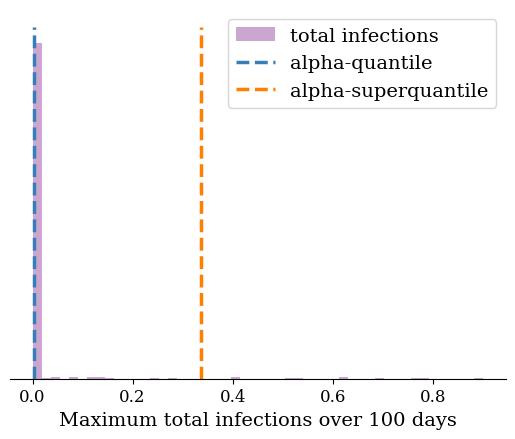

In [16]:
bins_hist = 50
fig1 = plt.figure()
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=18.)
cax = plt.gca()
sideaxishist(cax)
cax.hist(sq_qoi, color=co[2], bins=bins_hist, histtype='stepfilled', alpha=0.5, label='total infections')
miny = min(cax.get_ylim())
maxy = max(cax.get_ylim())
cax.vlines(q_sv, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-quantile', color=co[0])
cax.vlines(sq_sv, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-superquantile', color=co[1])
cax.set_xlabel('Maximum total infections over 100 days', size=14)
cax.legend(loc='upper right', prop={'size': 14})

## Risk-based optimization under uncertainty with intervention on detection rate parameter $\epsilon$
**NOTE:** This is a demonstration of the interface, optimization is not run to convergence nor are enough samples generated to accurately estimate the risk, so take the results with a grain of salt.

In [17]:
# Define problem specifics.
RISK_BOUND = 1./3.
X_MIN = 0.
X_MAX = 3.
N_SAMPLES = int(5e2)
MAXITER = 0
MAXFEVAL = 30
# TOL = 1e-5

RISK_ALPHA = 0.95

# Control action / intervention.
INIT_GUESS = 0.6
# INTERVENTION = lambda x: parameter_intervention_builder("nu", torch.tensor(x))
INTERVENTION = lambda x: {"epsilon": torch.from_numpy(np.array([x])), "theta": torch.from_numpy(2*np.array([x]))}

# Objective function.
OBJFUN = lambda x: x  # minimize the scalar value itself.

In [18]:
# Define the risk measure.
RISK = computeRisk(
                        model=ode_model,
                        intervention_fun=INTERVENTION,
                        qoi=lambda y: max_total_infections_SIDARTHE(y, contexts=["I_total_obs"]),
                        model_state=final_observed_state,
                        tspan=new_tspan,
                        risk_measure=lambda z: alpha_superquantile(z, alpha=RISK_ALPHA),
                        num_samples=N_SAMPLES,
                        guide=None,
                        )

# Define problem constraints.
CONSTRAINTS = (
                # risk constraint
                {'type': 'ineq', 'fun': lambda x: RISK_BOUND - RISK(x)},

                # bounds on control
                # NOTE: perhaps use scipy.optimize.LinearConstraint in the future
                {'type': 'ineq', 'fun': lambda x: x - X_MIN},
                {'type': 'ineq', 'fun': lambda x: X_MAX - x}
               )

In [20]:
print("Performing risk-based optimization under uncertainty (using alpha-superquantile)...")
print(f"Estimated wait time {time_per_eval*N_SAMPLES*(MAXITER+1)*MAXFEVAL:.1f} seconds.")
start_time = time.time()
sq_result_1 = solveOUU(
                     x0=INIT_GUESS,
                     objfun=OBJFUN,
                     constraints=CONSTRAINTS,
                     maxiter=MAXITER,
                     maxfeval=MAXFEVAL,
                    ).solve()
print(f"Optimization completed in time {time.time()-start_time:.2f} seconds. Optimal epsilon:\t{sq_result_1.x}")
# est_risk_sq1 = RISK(sq_result_1.x)
# print(f"Estimated risk:\t{est_risk_sq1:.2f}")

Performing risk-based optimization under uncertainty (using alpha-superquantile)...
Estimated wait time 2489.9 seconds.
Optimization completed in time 1647.29 seconds. Optimal epsilon:	0.579294986260515


In [21]:
# Define the risk measure.
RISK = computeRisk(
                        model=ode_model,
                        intervention_fun=INTERVENTION,
                        qoi=lambda y: max_total_infections_SIDARTHE(y, contexts=["I_total_obs"]),
                        model_state=final_observed_state,
                        tspan=new_tspan,
                        risk_measure=lambda z: alpha_quantile(z, alpha=RISK_ALPHA),
                        num_samples=N_SAMPLES,
                        guide=None,
                        )

# Define problem constraints.
CONSTRAINTS = (
                # risk constraint
                {'type': 'ineq', 'fun': lambda x: RISK_BOUND - RISK(x)},

                # bounds on control
                # NOTE: perhaps use scipy.optimize.LinearConstraint in the future
                {'type': 'ineq', 'fun': lambda x: x - X_MIN},
                {'type': 'ineq', 'fun': lambda x: X_MAX - x}
               )

In [22]:
print("Performing risk-based optimization under uncertainty (using alpha-quantile)...")
print(f"Estimated wait time {time_per_eval*N_SAMPLES*(MAXITER+1)*MAXFEVAL:.1f} seconds.")
start_time = time.time()
q_result_1 = solveOUU(
                     x0=INIT_GUESS,
                     objfun=OBJFUN,
                     constraints=CONSTRAINTS,
                     maxiter=MAXITER
                    ).solve()
print(f"Optimization completed in time {time.time()-start_time:.2f} seconds. Optimal epsilon:\t{q_result_1.x}")
# est_risk_q1 = RISK(q_result_1.x)
# print(f"Estimated risk:\t{est_risk_q1:.2f}")

Performing risk-based optimization under uncertainty (using alpha-quantile)...
Estimated wait time 2489.9 seconds.
Optimization completed in time 1818.54 seconds. Optimal epsilon:	0.4978249544803743


## Assess the effect of the control policy.

In [23]:
RISK.num_samples = int(5e2)
q_optimal_prediction = RISK.propagate_uncertainty(q_result_1.x)
sq_optimal_prediction = RISK.propagate_uncertainty(sq_result_1.x)
qois_q = RISK.qoi(q_optimal_prediction)
qois_sq = RISK.qoi(sq_optimal_prediction)
# sq_sv = RISK.risk_measure(qois_q)
# RISK.risk_measure = alpha_quantile
# q_sv = RISK(POLICY)

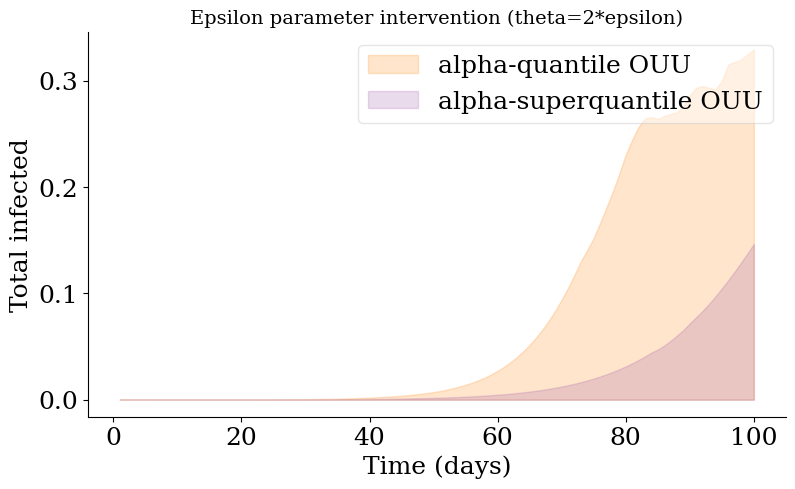

In [24]:
ax = setup_ax()
ax = plot_predictive(q_optimal_prediction, new_tspan, ax=ax, color=co[1], label="alpha-quantile OUU")
ax = plot_predictive(sq_optimal_prediction, new_tspan, ax=ax, color=co[2], label="alpha-superquantile OUU")
plt.title("Epsilon parameter intervention (theta=2*epsilon)", size=14)
sideaxis(ax)

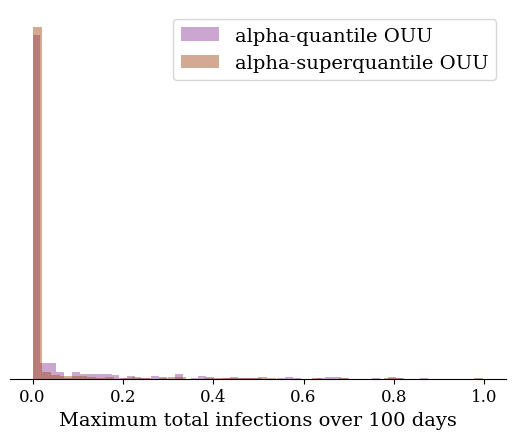

In [25]:
bins_hist = 50
fig1 = plt.figure()
plt.rc('font', family='serif', size=14.)
cax = plt.gca()
sideaxishist(cax)
cax.hist(qois_q, color=co[2], bins=bins_hist, histtype='stepfilled', alpha=0.5, label="alpha-quantile OUU", density=True)
cax.hist(qois_sq, color=co[4], bins=bins_hist, histtype='stepfilled', alpha=0.5, label="alpha-superquantile OUU", density=True)
miny = min(cax.get_ylim())
maxy = max(cax.get_ylim())
# cax.vlines(est_risk, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-superquantile', color=co[1])
cax.set_xlabel('Maximum total infections over 100 days', size=14)
cax.legend(loc='upper right', prop={'size': 14})